# Frequency Assignment with Real Data

Lucerne University of Applied Sciences and Arts - School of Information Technology

@author: Tobias Mérinat

You are given part of the Swisscom LTE Antenna data. The file contains all existing neighboring relations as well as candidate relations for future cells for a selected area (not all of Switzerland).

<img src="https://upload.wikimedia.org/wikipedia/en/5/59/Swisscom_logo.svg" width='200'/>

Your task is to assign a PCI (physicalLayerCellId) to each cell, without `collisions` and `confusions` and using the `minimize the number of PCIs`.

PCIs can be between 0 and 503. More details can be found in the paper [Physical Cell ID Allocation in Cellular Networks](https://www.diva-portal.org/smash/get/diva2:940787/FULLTEXT01.pdf) by Sofia Nyberg. See page 2 for an explanation on collisions and confusions.

Collision | Confusion
--- | ---
<img src="data/collision.png" height='100'> | <img src="data/confusion.png" height='100'>

In the real world, there are also some additional constraints that we will not consider in this exercise. One example of such an additional constraint is the restriction of certain PCIs around the country boarder.

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import colorsys

from ortools.constraint_solver import pywrapcp
from itertools import combinations
from tqdm import tqdm_notebook

tqdm_notebook().pandas()  # innitialize tqdm
%matplotlib inline

Read in cell data

In [2]:
edges = pd.read_fwf("data/nbrs.txt", header=None, names=['x', 'y'], dtype=str)
edges.head()

,x,y
0,X00645,X00457
1,X00057,X00457
2,X01522,X00457
3,X00044,X00457
4,X01204,X00457


During development, you might want to shorten the graph to decrease computation time.

In [3]:
edges = edges.head(100)

Create a list of vertices

In [4]:
vertices = pd.Series(np.sort(pd.concat([edges.x, edges.y]).unique()))

Map edges from strings to numbers

In [5]:
edges.x = edges.x.progress_apply(lambda i: (vertices==i).idxmax())
edges.y = edges.y.progress_apply(lambda i: (vertices==i).idxmax())

The data now looks as follows

In [6]:
vertices.shape, edges.shape

((67,), (100, 2))

In [7]:
vertices.head()

0    X00027
1    X00043
2    X00044
3    X00057
4    X00108
dtype: object

In [8]:
edges.head()

,x,y
0,21,11
1,3,11
2,46,11
3,2,11
4,39,11


Graph size as number of cells (nodes)

In [9]:
size = len(vertices)

Number of available PCIs

In [10]:
pci_len = 503

Create constraint solver

In [11]:
solver = pywrapcp.Solver("Graph Coloring")

In [12]:
# Type your model here ...

In [13]:
#cells = ...
#objective = ...

# solution below

Configure variables

In [14]:
cells = [solver.IntVar(0, pci_len) for i in range(size)]

Avoid collision: No neighboring cells may have the same PCI

In [15]:
constraints = edges.values.tolist()

Avoid confusion: No cell may have two neighbors with the same PCI

In [16]:
for vertex in vertices.index:
    neighbors = edges[edges.x==vertex].y.tolist() + edges[edges.y==vertex].x.tolist()
    for c in combinations(neighbors, r=2):
        constraints.append(c)

Remove redundant constraints

In [17]:
print("Before: {}".format(len(constraints)))
constraints = list(set([(a, b) if a<b else (b, a) for a, b in constraints if a!=b]))
print("After:  {}".format(len(constraints)))

Before: 1136
After:  747


Add all constraints to solver

In [18]:
len(constraints)

747

In [19]:
for a, b in constraints:
    solver.Add(cells[a] != cells[b])

Objective (minimize the number of PCIs)

In [20]:
objective = solver.Minimize(solver.Max(cells).Var(), 1)  # 1 is the 'step', no idea why that is needed

# solution above

Configure solver

In [21]:
db = solver.Phase(cells, solver.INT_VAR_SIMPLE, solver.INT_VALUE_SIMPLE)

Start solver and add objective to search

In [22]:
solver.NewSearch(db, objective)
if solver.NextSolution():
#     for i, cell in enumerate(cells):
#         print("Vertex #{} has PCI {}".format(i, cell.Value()))
    solution = [n.Value() for n in cells]
else:
    print("no solution found")

print("For the {} antennas, a total of {} PCIs have been assigned.".format(size, len(set(solution))))

For the 67 antennas, a total of 29 PCIs have been assigned.


Cleanup

In [23]:
solver.EndSearch()

Print solver information

In [24]:
print("Solutions:\t\t{}".format(solver.Solutions()))
print("Solver lifetime:\t{:.1f}s".format(solver.WallTime()/1000))
print("Failures:\t\t{}".format(solver.Failures()))
print("Branches:\t\t{} ".format(solver.Branches()))

Solutions:		1
Solver lifetime:	0.2s
Failures:		0
Branches:		67 


Create a palette

In [25]:
def get_colors(num_colors):
    """ https://stackoverflow.com/a/9701141/2315949 """
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

colors = get_colors(len(set(solution)))
np.random.shuffle(colors)  # this helps a bit for connected nodes to get more distinguishable colors

The labels indicate the color number used, so similar colors can be better distingushed.
For a large number of nodes, lower the node_size to 50 and turn off the labels.

/home/tuxtimo/hslu/modules/hslu-aiso/env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


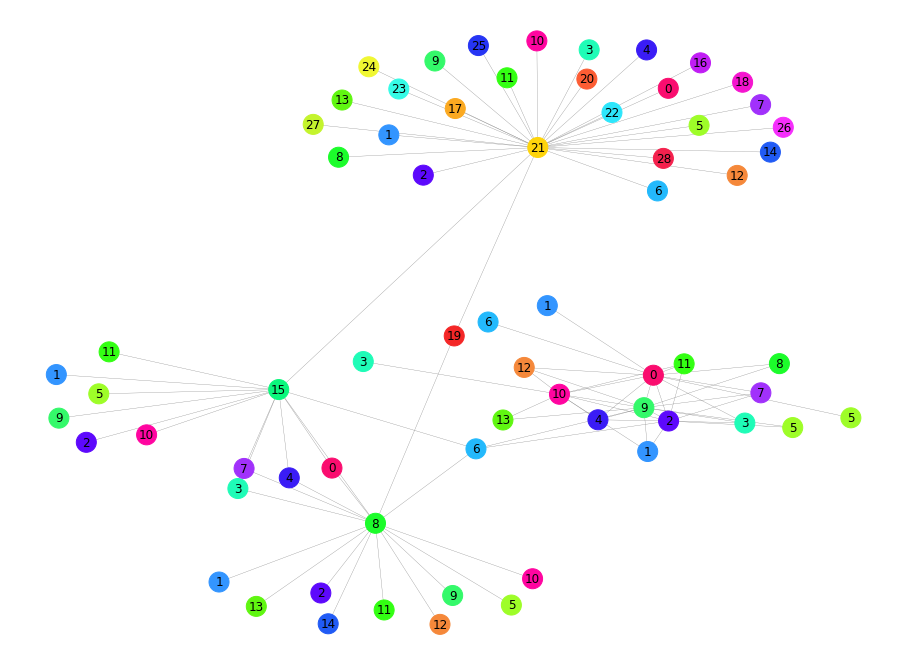

In [26]:
labels = {k:v for k, v in zip(vertices.index.tolist(), solution)}

G = nx.Graph()
G.add_nodes_from(vertices.index.tolist())
G.add_edges_from(edges.values.tolist())

plt.figure(figsize=(16,12))
nx.draw_networkx(G, with_labels=True, node_size=400, width=0.3, edge_color='grey', labels=labels,
                 layout=nx.spring_layout(G, k=0.1, iterations=50), node_color=[colors[i] for i in solution])
plt.axis('off')
plt.show()